In [14]:
import distribution_modules as dm
import density_estimation_modules as dem
import classification_modules as cm
import exploration_modules as expo
import importlib
# 
importlib.reload(dm)
importlib.reload(dem)
importlib.reload(cm)
importlib.reload(expo)

<module 'exploration_modules' from 'C:\\Users\\shfar\\Desktop\\SU\\Thesis\\thesis\\exploration_modules.py'>

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# set configuration
sample_size, nr_sample_sets, nr_moments = 1000, 20, 4
n_folds = 5
test_size = 0.2

## Bounded distributions

### same number of elements

In [17]:
bounded_dists = dm.get_bounded_distribution()
bounded_samples = dm.get_samples(bounded_dists, nr_sample_sets, sample_size)
#dm.plot_histograms_of_samples(bounded_samples)

In [18]:
moments_df = dem.get_moments(bounded_samples, nr_moments)
moments_df.head(3)

,m1,m2,m3,m4,label
0,0.328803,0.054296,0.006966,0.006937,beta_1_2
1,0.325356,0.056483,0.008560,0.008081,beta_1_2
2,0.314695,0.054682,0.008226,0.007484,beta_1_2


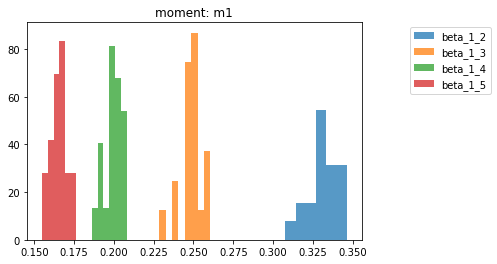

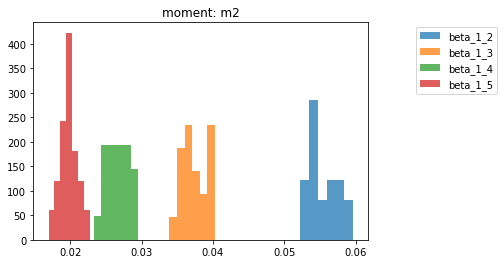

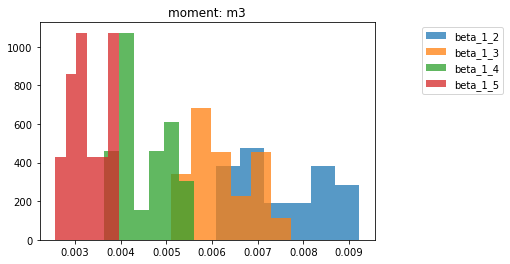

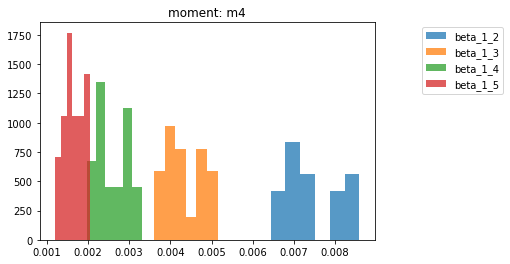

In [6]:
dem.get_histogram_of_moments(moments_df)

In [19]:
sample_size_list = [5, 10, 50, 100, 500, 1000]
nr_moments_list = np.arange(1,21)

#### SVM

In [20]:
cost = [0.01, 0.1, 0.5, 1, 5, 10]
gamma = [0.01, 0.1, 1, 5, 10]

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import hinge_loss
from sklearn.preprocessing import label_binarize
from functools import partial

In [118]:
sample_size = 100
nr_sample_sets=20
nr_moments = 4
n_folds = 5
cost = [0.01, 0.1, 0.5, 1, 5, 10]
gamma = [0.01, 0.1, 1, 5, 10]
bounded_dists = dm.get_bounded_distribution()
bounded_samples = dm.get_samples(bounded_dists, nr_sample_sets, sample_size)
data = dem.get_moments(bounded_samples, nr_moments)
X = data.iloc[:, :-1]
y = data.iloc[:,-1]
train_index_list, test_index_list = cm.split_n_folds(data, n_folds)

In [123]:
result = list()
for c in cost:
    for g in gamma:
        cv_error = list()
        for i in range(n_folds): 
            X_train = X.iloc[train_index_list[i]]
            y_train = y.iloc[train_index_list[i]]
            X_test = X.iloc[test_index_list[i]]
            y_test = y.iloc[test_index_list[i]]
            y_test = y_test.reset_index(drop=True)

                # standardize the data
            scaler_train = StandardScaler()
            scaler_train.fit(X_train)
            X_train_scaled = scaler_train.transform(X_train)
            X_test_scaled = scaler_train.transform(X_test)

            clf_svm = SVC(kernel='rbf', decision_function_shape ='ovr', class_weight='balanced', C=c, gamma=g)
            clf_svm.fit(X_train_scaled, y_train)
            #pred  = clf_svm.predict(X_test_scaled)
            
            # Convert y_test to a one-hot encoded format
            y_test_bin = label_binarize(y_test, classes=clf_svm.classes_)
            hingeloss = 0
            loss = list()
            for k in range(len(clf_svm.classes_)):
                hingeloss = hinge_loss(y_test_bin[:, k], clf_svm.decision_function(X_test_scaled)[:, k])
                loss.append(hingeloss)
            fold_loss =np.sum(loss)
            cv_error.append(fold_loss)
        result.append(dict(zip(['cv_error','cost','gamma'],[np.sum(cv_error)/n_folds, c, g])))
    
    result_df = pd.DataFrame(result)
    # find the best model, using one standard error rule
    res_agg = result_df.groupby(['cost','gamma'], as_index=False).agg({'cv_error':['mean','std']})
    res_agg.columns = ['cost','gamma','mean','std']
    res_agg['se']=res_agg['std']/np.sqrt(n_folds)
    min_err_index = np.argmin(res_agg['mean'])
    threshold = res_agg['mean'][min_err_index] + res_agg['se'][min_err_index]
    models = res_agg.loc[res_agg['mean']<=threshold]
    models_cost =list(models['cost'])
    models_gamma =list(models['gamma'])


In [121]:
 res_agg = result_df.groupby(['cost','gamma'], as_index=False).agg({'cv_error':['mean','std']})

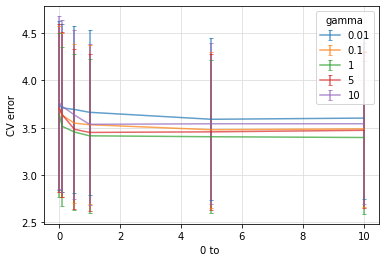

In [102]:
plt.figure()
for i in range(len(gamma)):
    data = res_agg.loc[res_agg['gamma']==gamma[i]]
    plt.errorbar(x=data['cost'], y=data['mean'], yerr=data['se'], label=gamma[i], capsize=2, alpha=0.7)
    
#sns.scatterplot(x=10, y=0, color='black')
#threshold_up = 0.478019 + 0.121844
#threshold_down = 0.478019 - 0.121844
#plt.axhline(y=threshold_up, ls='--', color='grey',linewidth=1)
#plt.axhline(y=threshold_down, ls='--', color='grey',linewidth=1)
#plt.scatter([10], [0.478019], color='red', zorder=10)
#plt.scatter([1], [0.575892], color='lightgreen', zorder=10)
plt.legend(title='gamma')
plt.xlabel('C')
plt.ylabel('CV error')
plt.grid(color='#DDDDDD')
plt.show()

In [142]:
res_svm = cm.cv_samplesize_moments_svm(sample_size_list, nr_moments_list, bounded_dists, nr_sample_sets, n_folds, test_size, cost, gamma)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

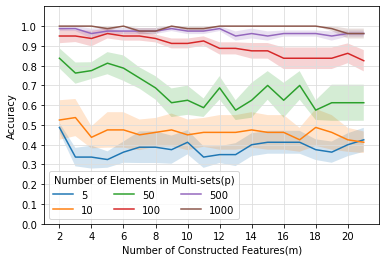

In [145]:
cm.plot_cv_moments_v2(res_svm)

#### Logistic Regression

In [143]:
C = [0.01, 0.1, 0.5, 1, 5, 10]

In [144]:
res_lr = cm.cv_samplesize_moments_lr(sample_size_list, nr_moments_list, bounded_dists, nr_sample_sets, n_folds, test_size, C)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

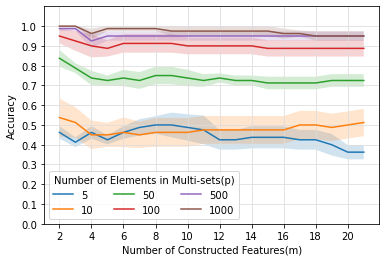

In [146]:
cm.plot_cv_moments_v2(res_lr)

### Varying number of elements

#### SVM

In [21]:
res_flex_svm = cm.cv_samplesize_moments_svm(sample_size_list, nr_moments_list, bounded_dists, nr_sample_sets, n_folds, test_size, cost, gamma, flex=True)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

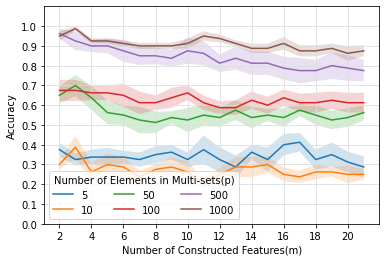

In [22]:
cm.plot_cv_moments_v2(res_flex_svm)

#### Logistic regression

In [148]:
res_flex_lr = cm.cv_samplesize_moments_lr(sample_size_list, nr_moments_list, bounded_dists, nr_sample_sets, n_folds, test_size, C, flex=True)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\shfar\Desktop\SU\Thesis\thesis\classification_modules.py:235: RuntimeWarning: divide by zero encountered in log
  loss = loss - np.log(sum(one_hot_matrix[j]*prob_row))
C:\Users\shfar\Desktop\SU\Thesis\thesis\classification_modules.py:235: RuntimeWarning: divide by zero encountered in log
  loss = loss - np.log(sum(one_hot_matrix[j]*prob_row))
C:\Users\shfar\Desktop\SU\Thesis\thesis\classification_modules.py:235: RuntimeWarning: divide by zero encountered in log
  loss = loss - np.log(sum(one_hot_matrix[j]*prob_row))
C:\Users\shfar\Desktop\SU\Thesis\thesis\classification_modules.py:235: RuntimeWarning: divide by zero encountered in log
  loss = loss - np.log(sum(one_hot_matrix[j]*prob_row))
C:\Users\shfar\Desktop\SU\Thesis\thesis\classification_modules.py:235: RuntimeWarning: divide by zero encountered in log
  loss = loss - np.log(sum(one_hot_matrix[j]*prob_row))
C:\Users\shfar\Desktop\SU\Thesis\thesis\classification_modules.py:235: RuntimeWarning: divide by zero encountered i

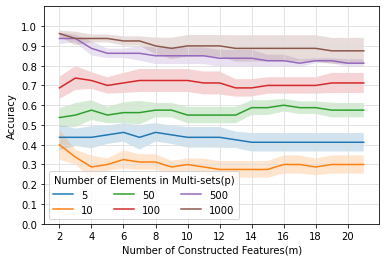

In [149]:
cm.plot_cv_moments_v2(res_flex_lr)

In [27]:
from functools import partial
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [16]:
m = 3
partial_moments = partial(dem.get_moments_partial, nr_moments=m)
moments_res = data['sample_set'].apply(partial_moments)
moments_df = pd.DataFrame(moments_res.tolist())
moments_df['label'] = data['label']
moments_df            

,0,1,2,label
0,0.313621,0.000000,0.000000e+00,beta_1_2
1,0.195249,0.006207,0.000000e+00,beta_1_2
2,0.221490,0.047208,6.311157e-03,beta_1_2
3,0.156876,0.000206,-8.682088e-21,beta_1_2
4,0.219027,0.015605,-1.314412e-03,beta_1_2
...,...,...,...,...
75,0.121124,0.006808,2.457776e-04,beta_1_5
76,0.182556,0.004345,0.000000e+00,beta_1_5
77,0.369684,0.008504,5.722993e-04,beta_1_5
78,0.244067,0.040958,2.220413e-03,beta_1_5


In [18]:
score = cm.lr_model_m(moments_df, n_folds, c_vector)
score

[0.25, 0.25, 0.3125, 0.375, 0.3125]

In [29]:
C = [0.1]
X = moments_df.iloc[:, :-1]
y = moments_df.iloc[:,-1]
train_index_list, test_index_list = cm.split_n_folds(data, n_folds)

In [30]:
result = list()
for c in C:
    cv_error = list()
    for i in range(1):
        X_train = X.iloc[train_index_list[i]]
        y_train = y.iloc[train_index_list[i]]
        X_test = X.iloc[test_index_list[i]]
        y_test = y.iloc[test_index_list[i]]
        y_test = y_test.reset_index(drop=True)
 
        # standardize the data
        scaler_train = StandardScaler()
        scaler_train.fit(X_train)
        X_train_scaled = scaler_train.transform(X_train)
        X_test_scaled = scaler_train.transform(X_test)
        clf_lr = LogisticRegression(penalty ='l2', C=c, class_weight='balanced', multi_class='ovr')
        clf_lr.fit(X_train_scaled, y_train)
        prob = clf_lr.predict_proba(X_test_scaled)
        pred = clf_lr.predict(X_test_scaled)
            
        one_hot_matrix = list()
        for l in range(len(y_test)):
            one_hot_matrix.append(list((y_test[l] == clf_lr.classes_ )*1))
        loss = 0
        for j in range(len(y_test)):
            prob_row = prob[j]
            loss = loss - np.log(sum(one_hot_matrix[j]*prob_row))

        loss = loss/len(y_test)
        cv_error.append(loss)
        result.append( dict(zip(['cv_error','lambda'],[loss, 1/c]))) 
result_df = pd.DataFrame(result)


In [33]:
sum(one_hot_matrix[j]*prob_row)

0.27157161367980964

In [ ]:
# find the best model, using one standard error rule
res_agg = result_df.groupby(['lambda'], as_index=False).agg({'cv_error':['mean','std']})
res_agg.columns = ['lambda','mean','std']
res_agg['se']=res_agg['std']/np.sqrt(n_folds)
min_err_index = np.argmin(res_agg['mean'])
threshold = res_agg['mean'][min_err_index] + res_agg['se'][min_err_index]
models = res_agg.loc[res_agg['mean']<=threshold]
models_lambda =list(models['lambda'])


### standardized

#### svm

In [150]:
res_st_svm = cm.cv_samplesize_moments_svm(sample_size_list, nr_moments_list, bounded_dists, nr_sample_sets, n_folds, test_size, cost, gamma, standardize = True)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

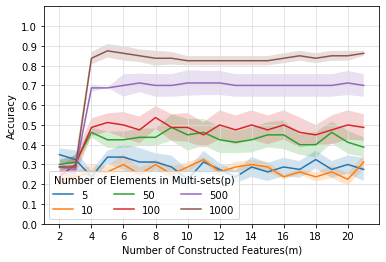

In [151]:
cm.plot_cv_moments_v2(res_st_svm)

#### logistic regression

In [152]:
res_st_lr = cm.cv_samplesize_moments_lr(sample_size_list, nr_moments_list, bounded_dists, nr_sample_sets, n_folds, test_size, C, standardize = True)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

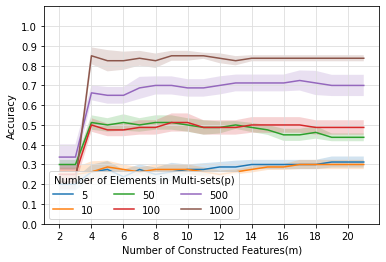

In [153]:
cm.plot_cv_moments_v2(res_st_lr)

## Heavytail distributions

In [10]:
heavytail_dists = dm.get_heavytail_distribution()
heavytail_samples = dm.get_samples(heavytail_dists, nr_sample_sets, sample_size, transform = True)
#dm.plot_histograms_of_samples(heavytail_samples)

In [11]:
nr_moments=1
moments_df = dem.get_moments(heavytail_samples, nr_moments)
moments_df.head(3)

,m1,label
0,0.906323,half_cauchy
1,0.954382,half_cauchy
2,0.892982,half_cauchy


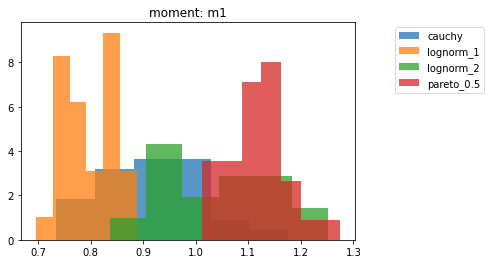

In [27]:
dem.get_histogram_of_moments(moments_df)

#### SVM

In [12]:
res_ht_svm = cm.cv_samplesize_moments_svm(sample_size_list, nr_moments_list, heavytail_dists, nr_sample_sets, n_folds, test_size, cost, gamma, transform=True)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

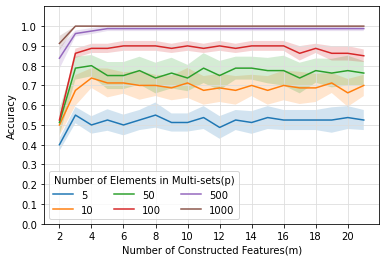

In [157]:
cm.plot_cv_moments_v2(res_ht_svm)

In [158]:
res_ht_svm = cm.cv_samplesize_moments_svm(sample_size_list, nr_moments_list, heavytail_dists, nr_sample_sets, n_folds, test_size, cost, gamma)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

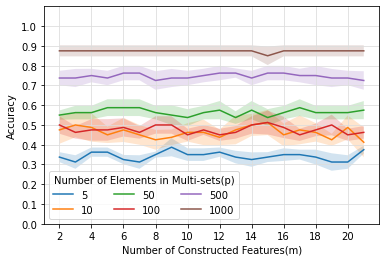

In [159]:
cm.plot_cv_moments_v2(res_ht_svm)

#### Logistic Regression

In [160]:
res_ht_lr = cm.cv_samplesize_moments_lr(sample_size_list, nr_moments_list, heavytail_dists, nr_sample_sets, n_folds, test_size, C, transform=True)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

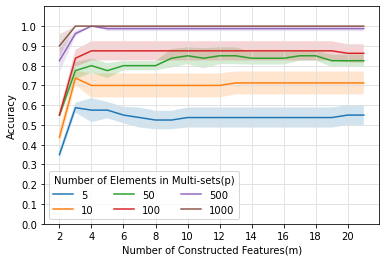

In [161]:
cm.plot_cv_moments_v2(res_ht_lr)

In [54]:
res_ht_lr

,nr_moments,sample_size,mean,std,se,nr_features
0,1,5,0.291667,0.041667,0.018634,2
1,1,10,0.408333,0.061802,0.027639,2
2,1,50,0.541667,0.051031,0.022822,2
3,1,100,0.591667,0.099478,0.044488,2
4,1,500,0.833333,0.051031,0.022822,2
5,1,1000,0.925000,0.068465,0.030619,2
6,2,5,0.600000,0.037268,0.016667,3
7,2,10,0.650000,0.047507,0.021246,3
8,2,50,0.808333,0.086402,0.038640,3
9,2,100,0.841667,0.074536,0.033333,3


### Multi-modal

In [162]:
nr_modes = 5
nr_sample_sets = 20
nr_mm_dist = 10
sample_size=100

In [163]:
mm_df= dm.get_multimodal_dists(nr_mm_dist, nr_sample_sets, nr_modes, sample_size)
moments_df = dem.get_moments(mm_df, 10)
moments_df.head(3)

,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,label
0,5.813719,2.890397,-0.368718,25.407890,-22.743259,363.852147,-757.417380,7047.683538,-22759.847992,161178.704777,Dist 01
1,5.914077,2.849255,-0.992855,23.236899,-21.507097,278.868031,-431.912879,4092.399292,-9370.212652,69363.335219,Dist 01
2,5.890860,2.807722,-0.831676,23.495262,-24.146790,304.758710,-605.507087,5080.209607,-15154.522667,99765.573594,Dist 01


#### SVM

In [164]:
res_mm_svm = cm.cv_samplesize_moments_svm_mm(sample_size_list, nr_moments_list, nr_sample_sets, nr_mm_dist, nr_modes, n_folds, test_size, cost, gamma)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

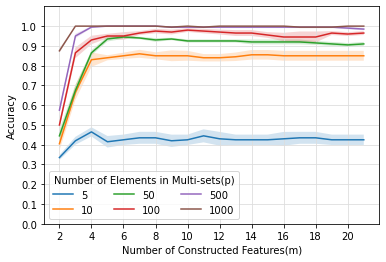

In [165]:
cm.plot_cv_moments_v2(res_mm_svm)

#### Logistic Regression

In [166]:
res_mm_lr = cm.cv_samplesize_moments_lr_mm(sample_size_list, nr_moments_list, nr_sample_sets, nr_mm_dist, nr_modes, n_folds, test_size, C)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\shfar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\shfar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

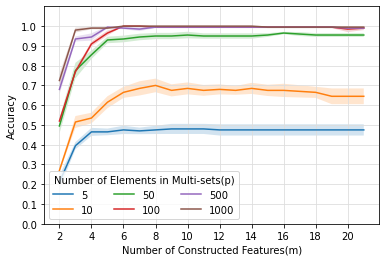

In [167]:
cm.plot_cv_moments_v2(res_mm_lr)

In [38]:
res_svm.to_csv('results/moments/res_svm_bounded.csv')
res_flex_svm.to_csv('results/moments/res_svm_bounded_flex.csv')
res_ht_svm.to_csv('results/moments/res_svm_heavytail.csv')
res_mm_svm.to_csv('results/moments/res_svm_multimodal.csv')

res_lr.to_csv('results/moments/res_lr_bounded.csv')
res_flex_lr.to_csv('results/moments/res_svm_bounded_flex.csv')
res_ht_lr.to_csv('results/moments/res_lr_heavytail.csv')
res_mm_lr.to_csv('results/moments/res_lr_multimodal.csv')

# figures for report

In [6]:
cost = [0.01, 0.1, 0.5, 1, 3, 5, 7, 10]
gamma = [0.01, 0.1, 1, 5, 10]

In [114]:
# set configuration
sample_size, nr_sample_sets, nr_moments = 100, 20, 5
n_folds = 5
test_size = 0.2

bounded_dists = dm.get_bounded_distribution()
bounded_samples = dm.get_samples(bounded_dists, nr_sample_sets, sample_size)

moments_df = dem.get_moments(bounded_samples, nr_moments)
moments_df.head(3)

,m1,m2,m3,m4,m5,label
0,0.320220,0.057638,0.008811,0.008488,0.003066,beta_1_2
1,0.320307,0.053861,0.005825,0.005708,0.001405,beta_1_2
2,0.310869,0.045293,0.008445,0.006562,0.002707,beta_1_2


In [115]:
#grid search svm
best_cost, best_gamma, result = cm.grid_search_svm(moments_df, 5, cost, gamma)

In [31]:
best_cost

5.0

In [32]:
best_gamma

0.1

In [116]:
res_agg = result.groupby(['cost','gamma'], as_index=False).agg({'cv_error':['mean','std']})
res_agg.columns = ['cost','gamma','mean','std']
res_agg['se']=res_agg['std']/np.sqrt(5)

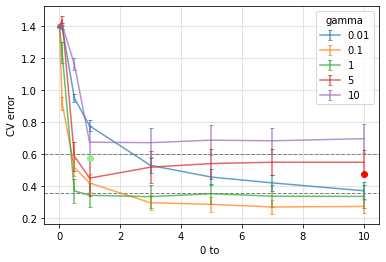

In [118]:
plt.figure()
for i in range(len(gamma)):
    data = res_agg.loc[res_agg['gamma']==gamma[i]]
    plt.errorbar(x=data['cost'], y=data['mean'], yerr=data['se'], label=gamma[i], capsize=2, alpha=0.7)
    
#sns.scatterplot(x=10, y=0, color='black')
threshold_up = 0.478019 + 0.121844
threshold_down = 0.478019 - 0.121844
plt.axhline(y=threshold_up, ls='--', color='grey',linewidth=1)
plt.axhline(y=threshold_down, ls='--', color='grey',linewidth=1)
plt.scatter([10], [0.478019], color='red', zorder=10)
plt.scatter([1], [0.575892], color='lightgreen', zorder=10)
plt.legend(title='gamma')
plt.xlabel('0 to ')
plt.ylabel('CV error')
plt.grid(color='#DDDDDD')
plt.show()

In [45]:
res_agg

,cost,gamma,mean,std,se
0,0.01,0.01,1.402773,0.027425,0.012265
1,0.01,0.10,1.413632,0.013529,0.006050
2,0.01,1.00,1.408256,0.012939,0.005786
3,0.01,5.00,1.401430,0.007500,0.003354
4,0.01,10.00,1.409216,0.025616,0.011456
5,0.10,0.01,1.402978,0.025295,0.011312
6,0.10,0.10,0.970155,0.069926,0.031272
7,0.10,1.00,0.764633,0.068207,0.030503
8,0.10,5.00,1.456619,0.103876,0.046455
9,0.10,10.00,1.436773,0.016067,0.007186


In [174]:
C = [0.001, 0.01, 0.1, 0.2, 1, 2, 5, 7, 10]

In [175]:
lambda_, result = cm.grid_search_lr(moments_df, 5, C)

In [176]:
lambda_

0.1

In [177]:
res_agg = result.groupby(['lambda'], as_index=False).agg({'cv_error':['mean','std'], 'acc':['mean','std']})
res_agg.columns = ['lambda','cv_error_mean','cv_error_std','acc_mean','acc_std']
res_agg['cv_error_se']=res_agg['cv_error_std']/np.sqrt(5)
res_agg['C']=1/res_agg['lambda']
res_agg

,lambda,cv_error_mean,cv_error_std,acc_mean,acc_std,cv_error_se,C
0,0.100000,0.595395,0.089608,0.825000,0.157012,0.040074,10.000
1,0.142857,0.614482,0.083607,0.825000,0.157012,0.037390,7.000
2,0.200000,0.633906,0.078484,0.825000,0.157012,0.035099,5.000
3,0.500000,0.693645,0.067229,0.841667,0.139443,0.030066,2.000
4,1.000000,0.744323,0.060833,0.850000,0.149071,0.027205,1.000
5,5.000000,0.872628,0.049128,0.816667,0.173305,0.021971,0.200
6,10.000000,0.931599,0.047270,0.775000,0.140064,0.021140,0.100
7,100.000000,1.138112,0.025273,0.650000,0.075691,0.011302,0.010
8,1000.000000,1.321189,0.003484,0.591667,0.099478,0.001558,0.001


In [178]:
(2*np.log(2))

1.3862943611198906

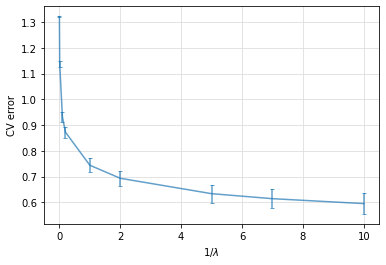

In [197]:
#plt.figure(figsize=(12, 8))
plt.errorbar(x=res_agg['C'], y=res_agg['cv_error_mean'], yerr=res_agg['cv_error_se'], capsize=2, alpha=0.7)
    
#sns.scatterplot(x=10, y=0, color='black')
#threshold_up = 2.584197 + 0.061599*4
#threshold_down = 2.584197 - 0.061599*4
#plt.axhline(y=threshold_up, ls='--', color='grey',linewidth=1)
#plt.axhline(y=threshold_down, ls='--', color='grey',linewidth=1)
#plt.scatter([5], [2.818729], color='red', zorder=10)
#plt.scatter([10], [2.584197], color='lightgreen', zorder=10)
#plt.xscale('log')
plt.xlabel('1/$\lambda$')
plt.ylabel('CV error')
plt.grid(color='#DDDDDD')
plt.show()

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [150]:
data = moments_df
c= 100
X = data.iloc[:, :-1]
y = data.iloc[:,-1]
train_index_list, test_index_list = cm.split_n_folds(data, n_folds)
result = list()
cv_error = list()
for i in range(n_folds):
    X_train = X.iloc[train_index_list[i]]
    y_train = y.iloc[train_index_list[i]]
    X_test = X.iloc[test_index_list[i]]
    y_test = y.iloc[test_index_list[i]]
    y_test = y_test.reset_index(drop=True)
 
    # standardize the data
    scaler_train = StandardScaler()
    scaler_train.fit(X_train)
    X_train_scaled = scaler_train.transform(X_train)
    X_test_scaled = scaler_train.transform(X_test)
    clf_lr = LogisticRegression(penalty ='l2', C=c, class_weight='balanced', multi_class='ovr')
    clf_lr.fit(X_train_scaled, y_train)
    prob = clf_lr.predict_proba(X_train_scaled)
    pred = clf_lr.predict(X_train_scaled)
    
    one_hot_matrix = list()
    for i in range(len(y_test)):
        one_hot_matrix.append(list((y_test[i] == clf_lr.classes_ )*1))
    
    loss = 0
    acc= 0
    for j in range(len(y_test)):
        prob_row=prob[j]
        loss = loss - np.log(sum(one_hot_matrix[0]*prob_row))
        if y_test[j] == pred[j]:
            acc = acc + 1
    loss = loss/len(y_test)
    acc = acc / len(y_test)
    
    cv_error.append(loss)
    result.append( dict(zip(['cv_error','lambda','acc'],[loss, 1/c, acc]))) 
result_df = pd.DataFrame(result)

In [151]:
result_df

,cv_error,lambda,acc
0,0.175095,0.01,0.25
1,0.185571,0.01,0.25
2,0.161045,0.01,0.25
3,0.194558,0.01,0.25
4,0.151411,0.01,0.25
